In [8]:
!head -n 100 annotations_sample.json

{
    "categories": [
        {
            "name": "shsy5y",
            "id": 1
        },
        {
            "name": "astro",
            "id": 2
        },
        {
            "name": "cort",
            "id": 3
        }
    ],
    "images": [
        {
            "id": "0030fd0e6378",
            "width": 704,
            "height": 520,
            "file_name": "train/0030fd0e6378.png"
        },
        {
            "id": "0140b3c8f445",
            "width": 704,
            "height": 520,
            "file_name": "train/0140b3c8f445.png"
        },
        {
            "id": "01ae5a43a2ab",
            "width": 704,
            "height": 520,
            "file_name": "train/01ae5a43a2ab.png"
        }
    ],
    "annotations": [
        {
            "segmentation": {
                "counts": [
                    299687,
                    7,
                    513,
                    19,
                    501,
                    25,
                    495,
   

In [4]:
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

dataDir=Path('./input')
annFile = Path('./input/annotations_all.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


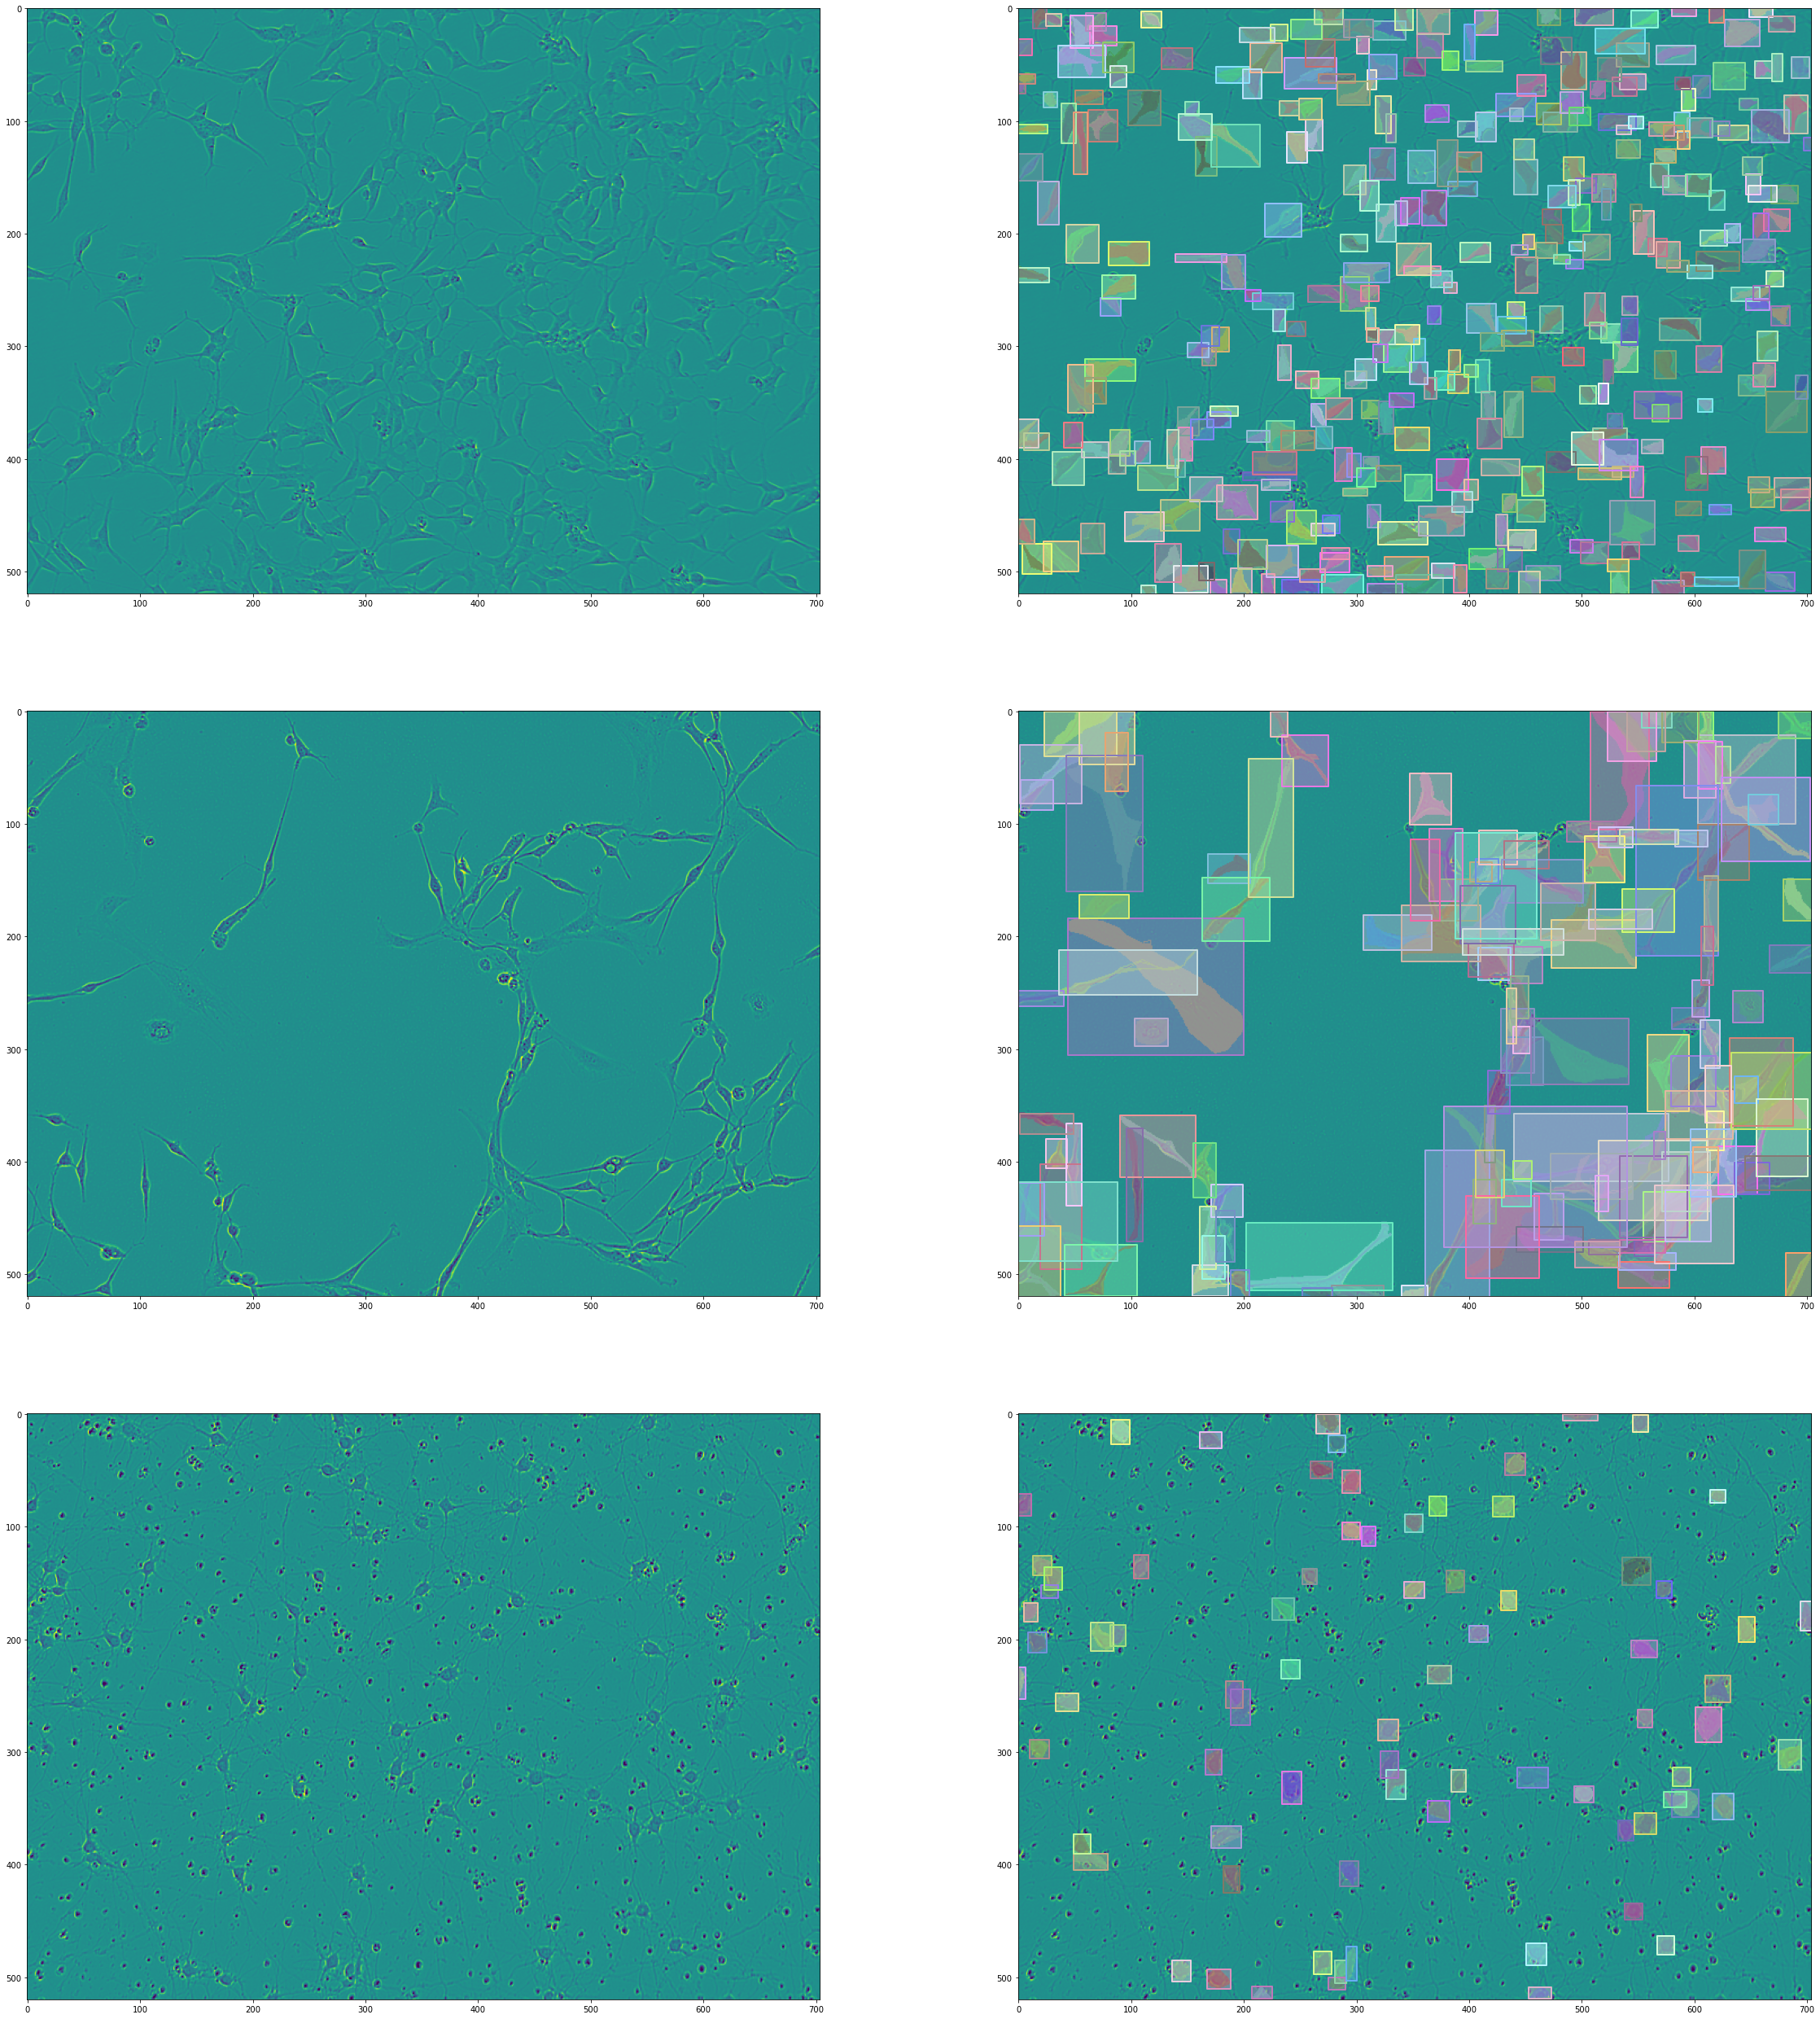

In [5]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [7]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import json,itertools

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def coco_structure(train_df):
    cat_ids = {name:id+1 for id, name in enumerate(train_df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in train_df.groupby('id').agg('first').iterrows()]
    annotations=[]
    for idx, row in tqdm(train_df.iterrows()):
        mk = rle_decode(row.annotation, (row.height, row.width))
        ys, xs = np.where(mk)
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)
        enc =binary_mask_to_rle(mk)
        seg = {
            'segmentation':enc, 
            'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
            'area': int(np.sum(mk)),
            'image_id':row.id, 
            'category_id':cat_ids[row.cell_type], 
            'iscrowd':0, 
            'id':idx
        }
        annotations.append(seg)
    return {'categories':cats, 'images':images,'annotations':annotations}

train_df = pd.read_csv('./input/train.csv')
all_ids = train_df.id.unique()
train_sample = train_df[train_df.id.isin(all_ids[:3])]
root = coco_structure(train_sample)

with open('annotations_sample.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)